📁 Using data from: sentiment_results
💾 Output will be saved to: sentiment_results\output_charts

📊 File CSV yang ditemukan: 5 files
   - gojek_reviews_high_confidence_20251130_170945.csv
   - gojek_reviews_labeled_20251130_170945.csv
   - gojek_reviews_negative_20251130_170945.csv
   - gojek_reviews_neutral_20251130_170945.csv
   - gojek_reviews_positive_20251130_170945.csv

📖 Reading files...
   ✅ Negative: 123617 comments
   ✅ Neutral: 719 comments
   ✅ Positive: 312158 comments

📊 SUMMARY - GOJEK SENTIMENT ANALYSIS
      Negative  Neutral  Positive
year                             
2021     17674       89     51721
2022     39709      271    121752
2023     27771      148     53806
2024     24243      126     51949
2025     14220       85     32930

------------------------------------------------------------
Total Negative: 123,617 comments
Total Neutral:  719 comments
Total Positive: 312,158 comments
------------------------------------------------------------
📊 GRAND TOTAL: 436,4

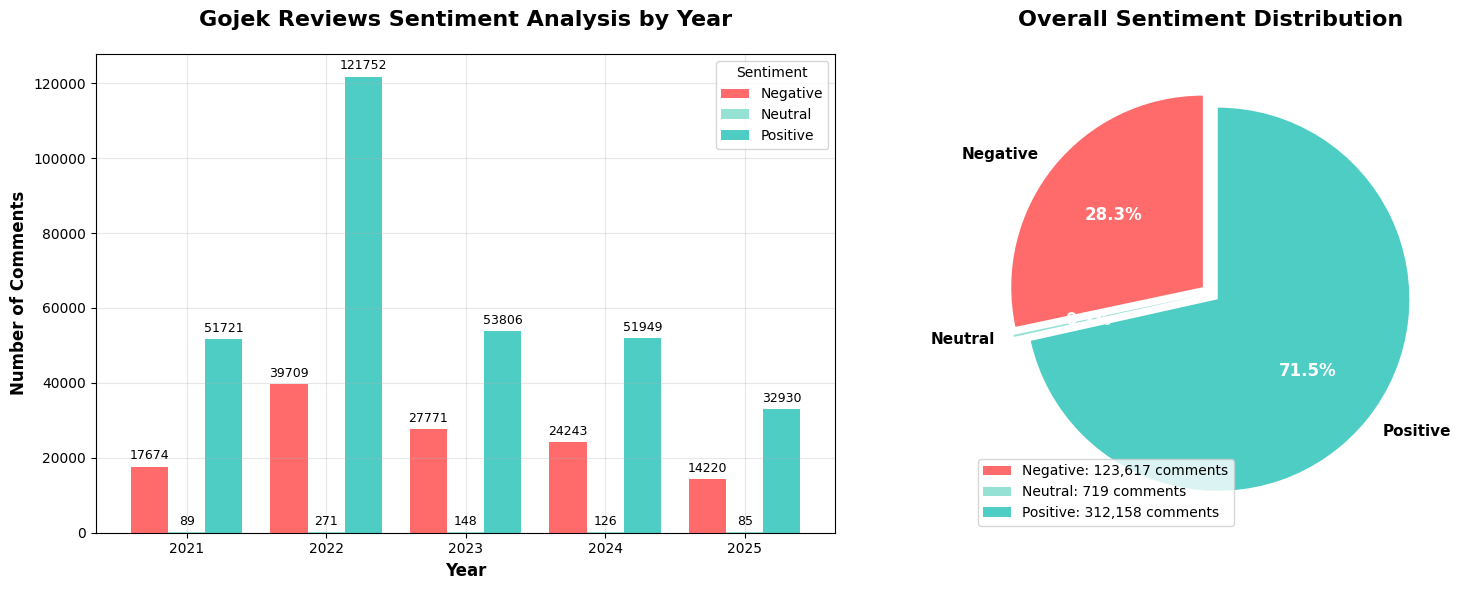

In [5]:
"""
Gojek Sentiment Analysis - Flexible Script
Bisa pake data dari sentiment_results ATAU data/raw
"""

import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

# Set style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# ============= CONFIGURATION =============
# Pilih salah satu:
USE_SENTIMENT_RESULTS = True  # True = pake sentiment_results, False = pake data/raw

# Path options - adjust sesuai environment lo
PROJECT_ROOT = Path('.')  # atau bisa '..' kalau script di subfolder

if USE_SENTIMENT_RESULTS:
    DATA_PATH = PROJECT_ROOT / 'sentiment_results'
else:
    DATA_PATH = PROJECT_ROOT / 'data' / 'raw'

OUTPUT_PATH = PROJECT_ROOT / 'sentiment_results' / 'output_charts'
# =========================================

print(f"📁 Using data from: {DATA_PATH}")
print(f"💾 Output will be saved to: {OUTPUT_PATH}")

# Buat output directory
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Coba baca semua file CSV yang ada
try:
    csv_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.csv')]
    csv_files.sort()
except Exception as e:
    print(f"❌ Error accessing directory: {e}")
    csv_files = []

print(f"\n📊 File CSV yang ditemukan: {len(csv_files)} files")
for f in csv_files:
    print(f"   - {f}")

if not csv_files:
    print("\n❌ Tidak ada file CSV yang ditemukan!")
    print(f"💡 Cek path: {DATA_PATH.absolute()}")
    exit(1)

# Dictionary untuk menyimpan data
sentiment_data = {}
all_data = []

# Baca semua file CSV
print("\n📖 Reading files...")
for file in csv_files:
    file_path = DATA_PATH / file
    try:
        df = pd.read_csv(file_path)
        
        # Tentukan sentiment berdasarkan nama file atau kolom
        if USE_SENTIMENT_RESULTS:
            # Dari sentiment_results: negative, neutral, positive
            if 'negative' in file.lower():
                sentiment_type = 'Negative'
            elif 'positive' in file.lower():
                sentiment_type = 'Positive'
            elif 'neutral' in file.lower():
                sentiment_type = 'Neutral'
            else:
                continue  # skip file yang bukan sentiment
        else:
            # Dari raw data: baca kolom sentiment/label
            if 'predicted_sentiment' in df.columns:
                sentiment_col = 'predicted_sentiment'
            elif 'sentiment' in df.columns:
                sentiment_col = 'sentiment'
            elif 'label' in df.columns:
                sentiment_col = 'label'
            else:
                print(f"⚠️  Skipping {file}: No sentiment column found")
                continue
            
            # Add sentiment info ke dataframe
            df['sentiment_type'] = df[sentiment_col]
        
        # Ekstrak tahun dari kolom 'at' atau 'created_at'
        date_col = 'at' if 'at' in df.columns else 'created_at'
        df['year'] = pd.to_datetime(df[date_col], errors='coerce').dt.year
        
        # Remove rows with invalid dates
        df = df.dropna(subset=['year'])
        df['year'] = df['year'].astype(int)
        
        if USE_SENTIMENT_RESULTS:
            # Hitung jumlah comment per tahun
            year_counts = df['year'].value_counts().sort_index()
            sentiment_data[sentiment_type] = year_counts
            print(f"   ✅ {sentiment_type}: {len(df)} comments")
        else:
            # Simpan untuk diproses nanti
            all_data.append(df)
            print(f"   ✅ {file}: {len(df)} comments")
        
    except Exception as e:
        print(f"   ❌ Error reading {file}: {e}")

# Process raw data jika tidak pake sentiment_results
if not USE_SENTIMENT_RESULTS and all_data:
    print("\n🔄 Processing raw data...")
    combined_df = pd.concat(all_data, ignore_index=True)
    
    # Group by year and sentiment
    for sentiment in combined_df['sentiment_type'].unique():
        sentiment_df = combined_df[combined_df['sentiment_type'] == sentiment]
        year_counts = sentiment_df['year'].value_counts().sort_index()
        
        # Normalize sentiment name
        if 'negatif' in str(sentiment).lower() or 'negative' in str(sentiment).lower():
            sentiment_data['Negative'] = year_counts
        elif 'positif' in str(sentiment).lower() or 'positive' in str(sentiment).lower():
            sentiment_data['Positive'] = year_counts
        elif 'netral' in str(sentiment).lower() or 'neutral' in str(sentiment).lower():
            sentiment_data['Neutral'] = year_counts

# Buat DataFrame gabungan
if not sentiment_data:
    print("\n❌ Tidak ada data sentiment yang berhasil dibaca!")
    exit(1)

# Gabungkan semua data
df_combined = pd.DataFrame(sentiment_data).fillna(0).astype(int)

# Reorder columns untuk consistency (Negative, Neutral, Positive)
desired_order = ['Negative', 'Neutral', 'Positive']
available_cols = [col for col in desired_order if col in df_combined.columns]
df_combined = df_combined[available_cols]

print("\n" + "="*60)
print("📊 SUMMARY - GOJEK SENTIMENT ANALYSIS")
print("="*60)
print(df_combined)
print("\n" + "-"*60)
print(f"Total Negative: {df_combined.get('Negative', pd.Series([0])).sum():,} comments")
print(f"Total Neutral:  {df_combined.get('Neutral', pd.Series([0])).sum():,} comments")
print(f"Total Positive: {df_combined.get('Positive', pd.Series([0])).sum():,} comments")
print("-"*60)
grand_total = df_combined.sum().sum()
print(f"📊 GRAND TOTAL: {grand_total:,} comments")
print("="*60)

# ============= VISUALIZATION =============
print("\n🎨 Creating charts...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Bar Chart per Tahun
color_map = {'Negative': '#FF6B6B', 'Neutral': '#95E1D3', 'Positive': '#4ECDC4'}
colors = [color_map[col] for col in df_combined.columns]

df_combined.plot(kind='bar', ax=ax1, width=0.8, color=colors)
ax1.set_title('Gojek Reviews Sentiment Analysis by Year', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Comments', fontsize=12, fontweight='bold')
ax1.legend(title='Sentiment', fontsize=10, loc='best')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=0)

# Tambahkan nilai di atas bar
for container in ax1.containers:
    ax1.bar_label(container, fontsize=9, padding=3)

# Chart 2: Pie Chart Total
total_sentiments = df_combined.sum()

# Filter out zero values
total_sentiments = total_sentiments[total_sentiments > 0]

pie_colors = [color_map[label] for label in total_sentiments.index]
explode = tuple([0.05] * len(total_sentiments))

wedges, texts, autotexts = ax2.pie(
    total_sentiments, 
    labels=total_sentiments.index, 
    autopct='%1.1f%%', 
    startangle=90, 
    colors=pie_colors, 
    explode=explode, 
    textprops={'fontsize': 11, 'fontweight': 'bold'}
)

# Make percentage text more visible
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

ax2.set_title('Overall Sentiment Distribution', fontsize=16, fontweight='bold', pad=20)

# Tambahkan legend dengan total
legend_labels = [f'{label}: {int(value):,} comments' for label, value in total_sentiments.items()]
ax2.legend(legend_labels, loc='lower left', fontsize=10)

plt.tight_layout()

# Save plot
output_file = OUTPUT_PATH / 'gojek_sentiment_analysis.png'
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Chart saved: {output_file}")

# Buat juga summary CSV
summary_file = OUTPUT_PATH / 'sentiment_summary.csv'
df_combined.to_csv(summary_file)
print(f"✅ Summary saved: {summary_file}")

# Save detailed summary dengan percentages
summary_with_pct = df_combined.copy()
summary_with_pct.loc['Total'] = summary_with_pct.sum()
summary_with_pct.loc['Percentage'] = (summary_with_pct.loc['Total'] / summary_with_pct.loc['Total'].sum() * 100).round(2)

summary_detailed = OUTPUT_PATH / 'sentiment_summary_detailed.csv'
summary_with_pct.to_csv(summary_detailed)
print(f"✅ Detailed summary saved: {summary_detailed}")

print("\n✅ DONE! Chart dan summary berhasil dibuat!")
print(f"📂 Check folder: {OUTPUT_PATH.absolute()}")

# Show plot (kalau running di notebook atau environment yang support display)
try:
    plt.show()
except:
    pass

In [10]:
"""
Gojek Sentiment Analysis - Department Categorization
Mengkategorikan comment berdasarkan 4 department:
1. Produk
2. Aplikasi
3. Kualitas Layanan
4. Layanan Pelanggan
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import re

# Set style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# ============= CONFIGURATION =============
PROJECT_ROOT = Path('.')
DATA_PATH = PROJECT_ROOT / 'sentiment_results'
OUTPUT_PATH = PROJECT_ROOT / 'sentiment_results' / 'department_analysis'
# =========================================

print("="*70)
print("📊 GOJEK DEPARTMENT SENTIMENT ANALYSIS")
print("="*70)

# Buat output directory
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# ============= DEPARTMENT KEYWORDS =============
# Keywords untuk setiap department
DEPARTMENT_KEYWORDS = {
    'Produk': [
        'goride', 'gocar', 'gofood', 'gosend', 'gomart', 'gomed', 'gopay',
        'produk', 'layanan', 'fitur', 'menu', 'makanan', 'restoran', 'toko',
        'belanja', 'pesan', 'order', 'orderan', 'kirim', 'antar', 'delivery'
    ],
    'Aplikasi': [
        'aplikasi', 'apk', 'app', 'login', 'daftar', 'register', 'akun', 'account',
        'loading', 'lemot', 'lag', 'crash', 'error', 'bug', 'glitch', 'hang',
        'update', 'versi', 'install', 'download', 'connection', 'koneksi',
        'interface', 'tampilan', 'ui', 'ux', 'notifikasi', 'notification'
    ],
    'Kualitas Layanan': [
        'driver', 'ojek', 'pengendara', 'pengemudi', 'motor', 'mobil',
        'cepat', 'lambat', 'lama', 'telat', 'terlambat', 'ontime', 'tepat waktu',
        'aman', 'nyaman', 'bersih', 'kotor', 'kasar', 'ramah', 'sopan',
        'kualitas', 'quality', 'service', 'pelayanan', 'cancel', 'batal',
        'rating', 'bintang', 'review', 'komplain', 'keluhan'
    ],
    'Layanan Pelanggan': [
        'customer service', 'cs', 'admin', 'call center', 'hotline',
        'komplain', 'lapor', 'report', 'bantuan', 'help', 'support',
        'respon', 'response', 'tanggap', 'solusi', 'refund', 'kembalikan',
        'uang', 'saldo', 'balance', 'dana', 'pembayaran', 'payment',
        'promo', 'voucher', 'diskon', 'discount', 'cashback', 'poin', 'point'
    ]
}

def categorize_department(text):
    """
    Kategorikan text berdasarkan department keywords
    Returns list of departments (bisa multiple)
    """
    if pd.isna(text):
        return []
    
    text = str(text).lower()
    departments = []
    
    for dept, keywords in DEPARTMENT_KEYWORDS.items():
        for keyword in keywords:
            if keyword in text:
                departments.append(dept)
                break  # udah ketemu keyword, next department
    
    # Return empty list jika gak ada kategori (akan di-filter nanti)
    return departments if departments else []

# ============= LOAD DATA =============
print(f"\n📁 Loading data from: {DATA_PATH}")

csv_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.csv')]
csv_files = [f for f in csv_files if any(x in f.lower() for x in ['negative', 'positive', 'neutral'])]

print(f"📊 Found {len(csv_files)} sentiment files")

all_data = []

for file in csv_files:
    file_path = DATA_PATH / file
    try:
        df = pd.read_csv(file_path)
        
        # Tentukan sentiment
        if 'negative' in file.lower():
            sentiment = 'Negative'
        elif 'positive' in file.lower():
            sentiment = 'Positive'
        elif 'neutral' in file.lower():
            sentiment = 'Neutral'
        else:
            continue
        
        df['sentiment'] = sentiment
        
        # Ambil kolom yang diperlukan
        if 'cleaned_text' in df.columns:
            text_col = 'cleaned_text'
        elif 'content' in df.columns:
            text_col = 'content'
        else:
            text_col = df.columns[0]
        
        df['text'] = df[text_col]
        
        all_data.append(df[['text', 'sentiment']])
        print(f"   ✅ {sentiment}: {len(df):,} comments")
        
    except Exception as e:
        print(f"   ❌ Error reading {file}: {e}")

if not all_data:
    print("\n❌ No data found!")
    exit(1)

# Gabungkan semua data
print("\n🔄 Processing data...")
combined_df = pd.concat(all_data, ignore_index=True)
print(f"📊 Total comments: {len(combined_df):,}")

# ============= CATEGORIZE BY DEPARTMENT =============
print("\n🏢 Categorizing by department...")

# Kategorikan setiap comment
combined_df['departments'] = combined_df['text'].apply(categorize_department)

# Expand departments (1 comment bisa masuk multiple departments)
# Using explode() method - lebih efficient dan gak error
df_expanded = combined_df.explode('departments')
df_expanded = df_expanded.rename(columns={'departments': 'department'})
df_expanded = df_expanded.reset_index(drop=True)

# Filter out comments tanpa kategori (fokus ke 4 department aja)
df_expanded = df_expanded[df_expanded['department'].notna()]
df_expanded = df_expanded[df_expanded['department'] != '']

print(f"✅ Categorized comments: {len(df_expanded):,}")
print(f"   (from {len(combined_df):,} total comments)")

# Show distribution
dept_dist = df_expanded['department'].value_counts()
print("\n📊 Distribution by department:")
for dept, count in dept_dist.items():
    pct = (count / len(df_expanded) * 100)
    print(f"   {dept:20s}: {count:6,} ({pct:5.1f}%)")

# ============= ANALYSIS =============
print("\n📊 Generating analysis...")

# Hitung jumlah per department dan sentiment
dept_sentiment_counts = df_expanded.groupby(['department', 'sentiment']).size().unstack(fill_value=0)

# Reorder columns
sentiment_order = ['Negative', 'Neutral', 'Positive']
available_sentiments = [s for s in sentiment_order if s in dept_sentiment_counts.columns]
dept_sentiment_counts = dept_sentiment_counts[available_sentiments]

# Sort by total (descending)
dept_sentiment_counts['Total'] = dept_sentiment_counts.sum(axis=1)
dept_sentiment_counts = dept_sentiment_counts.sort_values('Total', ascending=False)

print("\n" + "="*70)
print("📊 DEPARTMENT SENTIMENT BREAKDOWN")
print("="*70)
print(dept_sentiment_counts)
print("="*70)

# Calculate percentages
dept_sentiment_pct = dept_sentiment_counts.drop('Total', axis=1).div(
    dept_sentiment_counts['Total'], axis=0
) * 100

# ============= VISUALIZATION =============
print("\n🎨 Creating visualizations...")

# Create 3 separate figures for better clarity

# ========== FIGURE 1: STACKED BAR CHART ==========
fig1, ax1 = plt.subplots(figsize=(12, 7))

dept_sentiment_counts.drop('Total', axis=1).plot(
    kind='bar',
    stacked=True,
    ax=ax1,
    color=['#FF6B6B', '#95E1D3', '#4ECDC4'],
    width=0.7
)
ax1.set_title('Department Sentiment Distribution (Stacked)', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Department', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Comments', fontsize=12, fontweight='bold')
ax1.legend(title='Sentiment', fontsize=11, loc='upper right')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add total on top of bars
for i, dept in enumerate(dept_sentiment_counts.index):
    total = dept_sentiment_counts.loc[dept, 'Total']
    ax1.text(i, total + total*0.02, f'{int(total):,}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
output_file1 = OUTPUT_PATH / 'department_sentiment_stacked.png'
plt.savefig(output_file1, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Stacked chart saved: {output_file1}")
plt.close()

# ========== FIGURE 2: GROUPED BAR CHART ==========
fig2, ax2 = plt.subplots(figsize=(14, 7))

dept_sentiment_counts.drop('Total', axis=1).plot(
    kind='bar',
    ax=ax2,
    color=['#FF6B6B', '#95E1D3', '#4ECDC4'],
    width=0.8
)
ax2.set_title('Department Sentiment Distribution (Grouped)', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Department', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Comments', fontsize=12, fontweight='bold')
ax2.legend(title='Sentiment', fontsize=11, loc='upper right')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add value labels on bars
for container in ax2.containers:
    ax2.bar_label(container, fontsize=9, padding=3, fmt='%d')

plt.tight_layout()
output_file2 = OUTPUT_PATH / 'department_sentiment_grouped.png'
plt.savefig(output_file2, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Grouped chart saved: {output_file2}")
plt.close()

# ========== FIGURE 3: HEATMAP ==========
fig3, ax3 = plt.subplots(figsize=(10, 6))

sns.heatmap(
    dept_sentiment_counts.drop('Total', axis=1),
    annot=True,
    fmt='d',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Number of Comments'},
    ax=ax3,
    linewidths=1,
    linecolor='white',
    square=False,
    annot_kws={'fontsize': 11, 'fontweight': 'bold'}
)
ax3.set_title('Department-Sentiment Heatmap', fontsize=16, fontweight='bold', pad=20)
ax3.set_xlabel('Sentiment', fontsize=12, fontweight='bold')
ax3.set_ylabel('Department', fontsize=12, fontweight='bold')
plt.setp(ax3.yaxis.get_majorticklabels(), rotation=0)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
output_file3 = OUTPUT_PATH / 'department_sentiment_heatmap.png'
plt.savefig(output_file3, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Heatmap saved: {output_file3}")
plt.close()

# ========== FIGURE 4: PERCENTAGE STACKED BAR ==========
fig4, ax4 = plt.subplots(figsize=(12, 7))

# Calculate percentages for each department
dept_pct = dept_sentiment_counts.drop('Total', axis=1).div(
    dept_sentiment_counts['Total'], axis=0
) * 100

dept_pct.plot(
    kind='bar',
    stacked=True,
    ax=ax4,
    color=['#FF6B6B', '#95E1D3', '#4ECDC4'],
    width=0.7
)
ax4.set_title('Department Sentiment Distribution (Percentage)', fontsize=16, fontweight='bold', pad=20)
ax4.set_xlabel('Department', fontsize=12, fontweight='bold')
ax4.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax4.legend(title='Sentiment', fontsize=11, loc='upper right')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim(0, 100)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Add percentage labels on bars
for i, dept in enumerate(dept_pct.index):
    cumulative = 0
    for sentiment in dept_pct.columns:
        value = dept_pct.loc[dept, sentiment]
        if value > 5:  # Only show label if > 5%
            ax4.text(i, cumulative + value/2, f'{value:.1f}%', 
                    ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        cumulative += value

plt.tight_layout()
output_file4 = OUTPUT_PATH / 'department_sentiment_percentage.png'
plt.savefig(output_file4, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Percentage chart saved: {output_file4}")
plt.close()

# ============= SAVE RESULTS =============

# Save counts
counts_file = OUTPUT_PATH / 'department_sentiment_counts.csv'
dept_sentiment_counts.to_csv(counts_file)
print(f"✅ Counts saved: {counts_file}")

# Save percentages
pct_file = OUTPUT_PATH / 'department_sentiment_percentages.csv'
dept_sentiment_pct.to_csv(pct_file)
print(f"✅ Percentages saved: {pct_file}")

# Save detailed data (sample per department)
print("\n📝 Saving sample comments per department...")
for dept in dept_sentiment_counts.index:
    dept_data = df_expanded[df_expanded['department'] == dept].copy()
    
    # Sample 100 comments per sentiment
    dept_samples = []
    for sentiment in available_sentiments:
        sentiment_data = dept_data[dept_data['sentiment'] == sentiment]
        sample = sentiment_data.head(100)
        dept_samples.append(sample)
    
    if dept_samples:
        dept_combined = pd.concat(dept_samples)
        sample_file = OUTPUT_PATH / f'samples_{dept.lower().replace(" ", "_")}.csv'
        dept_combined.to_csv(sample_file, index=False)
        print(f"   ✅ {dept}: {len(dept_combined)} samples saved")

# ============= SUMMARY REPORT =============
print("\n" + "="*70)
print("📊 SUMMARY REPORT")
print("="*70)

for dept in dept_sentiment_counts.index:
    print(f"\n🏢 {dept.upper()}")
    print("-" * 50)
    row = dept_sentiment_counts.loc[dept]
    for sentiment in available_sentiments:
        count = row[sentiment]
        pct = (count / row['Total'] * 100) if row['Total'] > 0 else 0
        print(f"   {sentiment:10s}: {count:6,} comments ({pct:5.1f}%)")
    print(f"   {'Total':10s}: {row['Total']:6,} comments")

print("\n" + "="*70)
print("✅ ANALYSIS COMPLETE!")
print(f"📂 Results saved to: {OUTPUT_PATH.absolute()}")
print("\n📊 Generated files:")
print("   - department_sentiment_stacked.png")
print("   - department_sentiment_grouped.png")
print("   - department_sentiment_heatmap.png")
print("   - department_sentiment_percentage.png")
print("   - department_sentiment_counts.csv")
print("   - department_sentiment_percentages.csv")
print("   - samples_*.csv (per department)")
print("="*70)

📊 GOJEK DEPARTMENT SENTIMENT ANALYSIS

📁 Loading data from: sentiment_results
📊 Found 3 sentiment files
   ✅ Negative: 123,617 comments
   ✅ Neutral: 719 comments
   ✅ Positive: 312,158 comments

🔄 Processing data...
📊 Total comments: 436,494

🏢 Categorizing by department...
✅ Categorized comments: 351,618
   (from 436,494 total comments)

📊 Distribution by department:
   Kualitas Layanan    : 127,574 ( 36.3%)
   Aplikasi            : 94,033 ( 26.7%)
   Produk              : 77,476 ( 22.0%)
   Layanan Pelanggan   : 52,535 ( 14.9%)

📊 Generating analysis...

📊 DEPARTMENT SENTIMENT BREAKDOWN
sentiment          Negative  Neutral  Positive   Total
department                                            
Kualitas Layanan      62236      487     64851  127574
Aplikasi              57161      427     36445   94033
Produk                50828      450     26198   77476
Layanan Pelanggan     31186      233     21116   52535

🎨 Creating visualizations...
✅ Stacked chart saved: sentiment_results\de

In [4]:
"""
Gojek Department Deep Dive Analysis - FULLY AUTOMATIC
Analisis mendalam per department dengan auto-extraction:
- Positive keywords: Apa yang pelanggan suka
- Negative keywords: Apa yang pelanggan keluhkan
- Insight summary otomatis per department
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from pathlib import Path

plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

# ============= CONFIGURATION =============
PROJECT_ROOT = Path('.')
DATA_PATH = PROJECT_ROOT / 'sentiment_results'
OUTPUT_PATH = PROJECT_ROOT / 'sentiment_results' / 'department_insights'

TOP_N_KEYWORDS = 15
MIN_WORD_LENGTH = 3
# =========================================

print("="*80)
print("📊 DEPARTMENT DEEP DIVE ANALYSIS - FULLY AUTOMATIC")
print("="*80)

OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# ============= COMPREHENSIVE STOPWORDS =============
STOPWORDS = {
    'yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'dengan', 'untuk',
    'pada', 'adalah', 'oleh', 'dalam', 'atau', 'juga', 'akan', 'telah',
    'sudah', 'ada', 'tidak', 'saya', 'kamu', 'dia', 'mereka', 'kita',
    'kami', 'nya', 'mu', 'ku', 'lah', 'pun', 'kan', 'tapi', 'tetapi',
    'namun', 'karena', 'kalau', 'jika', 'bila', 'agar', 'supaya', 'saat',
    'waktu', 'ketika', 'saja', 'dulu', 'lagi', 'sih', 'dong', 'kok',
    'jadi', 'biar', 'nih', 'deh', 'aja', 'kalo', 'tau', 'mau', 'bisa',
    'udah', 'udh', 'gak', 'gue', 'gua', 'banget', 'weh', 'yg', 'dgn',
    'the', 'a', 'an', 'of', 'in', 'to', 'for', 'is', 'on', 'at', 'by',
    'sangat', 'sekali', 'lebih', 'paling', 'kurang', 'cukup', 'hanya',
    # Pronouns & possessives (REMOVE: aku, tolong, dll)
    'aku', 'saya', 'kamu', 'anda', 'beliau', 'ia', 'kalian',
    # Generic verbs (REMOVE: tolong, kasih, dll)
    'tolong', 'bantu', 'kasih', 'ambil', 'pake', 'pakai', 'buat', 'bikin',
    'coba', 'lihat', 'cari', 'minta', 'ajak', 'tau', 'tahu',
    # Generic adjectives (REMOVE: bagus, jelek, oke, mantap - terlalu umum)
    'baik', 'buruk', 'jelek', 'bagus', 'oke', 'ok', 'mantap', 'top',
    # App-related generic (REMOVE: aplikasi, aplikasinya, gojek)
    'aplikasi', 'aplikasinya', 'appnya', 'apk', 'app', 'gojek', 'gojeknya',
    # Generic expressions
    'gimana', 'kenapa', 'apa', 'siapa', 'kapan', 'dimana', 'mana',
    'begitu', 'begini', 'seperti', 'kayak', 'kaya', 'gitu', 'gt',
    # Intensifiers
    'amat', 'benar', 'bener', 'bgt',
    # Filler & connecting words
    'makanya', 'soalnya', 'terus', 'trus', 'abis', 'habis', 'setelah',
    'sebelum', 'selama', 'sampai', 'hingga', 'lho', 'loh', 'kek',
    # Generic nouns
    'hal', 'cara', 'orang', 'tempat', 'masalah', 'masalahnya',
    # Time markers
    'sekarang', 'nanti', 'besok', 'kemarin', 'hari', 'minggu', 'bulan',
    'tahun', 'jam', 'menit', 'detik', 'tadi', 'barusan', 'lalu', 'kemudian',
    'this', 'that', 'with', 'from', 'have', 'has', 'had', 'but', 'not',
    'are', 'was', 'were', 'been', 'be', 'as', 'or', 'if', 'so', 'do',
    # Additional generic words
    'senang', 'sedih', 'marah', 'kecewa', 'puas', 'seneng',
}

# ============= LOAD DATA WITH DEPARTMENTS =============
print(f"\n📁 Loading categorized data from previous analysis...")

# Load the department-categorized data from previous script
categorized_file = DATA_PATH / 'department_analysis' / 'samples_kualitas_layanan.csv'

# Check if department analysis was done
dept_files = {
    'Kualitas Layanan': DATA_PATH / 'department_analysis' / 'samples_kualitas_layanan.csv',
    'Aplikasi': DATA_PATH / 'department_analysis' / 'samples_aplikasi.csv',
    'Produk': DATA_PATH / 'department_analysis' / 'samples_produk.csv',
    'Layanan Pelanggan': DATA_PATH / 'department_analysis' / 'samples_layanan_pelanggan.csv',
}

all_dept_data = {}

for dept_name, filepath in dept_files.items():
    if filepath.exists():
        df = pd.read_csv(filepath)
        all_dept_data[dept_name] = df
        print(f"✅ Loaded {dept_name}: {len(df):,} comments")
    else:
        print(f"⚠️  {dept_name}: File not found, loading from raw files...")
        # Fallback: load from raw sentiment files and categorize on-the-fly
        # (simplified version - akan di-implement below)

# If no department files, load raw and categorize
if not all_dept_data:
    print("\n⚠️  Department analysis files not found!")
    print("Please run 'department_sentiment_analysis.py' first, or...")
    print("Loading from raw files and categorizing on-the-fly...")
    
    # Load raw sentiment files
    sentiment_dfs = {}
    for sentiment in ['Negative', 'Positive', 'Neutral']:
        for file in DATA_PATH.glob('*.csv'):
            if sentiment.lower() in file.name.lower():
                df = pd.read_csv(file)
                if 'cleaned_text' in df.columns:
                    text_col = 'cleaned_text'
                elif 'content' in df.columns:
                    text_col = 'content'
                else:
                    text_col = df.columns[0]
                
                df['text'] = df[text_col].astype(str)
                df['sentiment'] = sentiment
                sentiment_dfs[sentiment] = df
                break
    
    # Simple department keywords for fallback categorization
    dept_keywords_simple = {
        'Kualitas Layanan': ['driver', 'ojek', 'motor', 'cepat', 'lambat', 'ramah', 'kasar', 'cancel'],
        'Aplikasi': ['aplikasi', 'app', 'login', 'error', 'bug', 'loading', 'lemot', 'crash'],
        'Produk': ['gofood', 'goride', 'gocar', 'gosend', 'gopay', 'gomart', 'produk'],
        'Layanan Pelanggan': ['cs', 'admin', 'komplain', 'respon', 'refund', 'promo', 'voucher'],
    }
    
    # Categorize by department
    for dept_name, keywords in dept_keywords_simple.items():
        dept_comments = []
        for sentiment, df in sentiment_dfs.items():
            for _, row in df.iterrows():
                text_lower = row['text'].lower()
                if any(kw in text_lower for kw in keywords):
                    dept_comments.append({
                        'text': row['text'],
                        'sentiment': sentiment
                    })
        
        if dept_comments:
            all_dept_data[dept_name] = pd.DataFrame(dept_comments)
            print(f"✅ Categorized {dept_name}: {len(dept_comments):,} comments")

# ============= EXTRACT KEYWORDS FUNCTION =============
def extract_keywords(texts, top_n=15, stopwords=None):
    """Extract top keywords from list of texts"""
    if stopwords is None:
        stopwords = set()
    
    all_words = []
    for text in texts:
        words = re.findall(r'\b\w+\b', str(text).lower())
        words = [w for w in words 
                if len(w) >= MIN_WORD_LENGTH 
                and not w.isdigit() 
                and w not in stopwords]
        all_words.extend(words)
    
    word_counts = Counter(all_words)
    return word_counts.most_common(top_n)

def extract_unique_keywords(pos_texts, neg_texts, top_n=15, stopwords=None):
    """
    Extract keywords that are UNIQUE or dominant in one sentiment
    Returns: (positive_unique, negative_unique)
    """
    if stopwords is None:
        stopwords = set()
    
    # Extract all words from each sentiment
    pos_words = []
    neg_words = []
    
    for text in pos_texts:
        words = re.findall(r'\b\w+\b', str(text).lower())
        words = [w for w in words if len(w) >= MIN_WORD_LENGTH and not w.isdigit() and w not in stopwords]
        pos_words.extend(words)
    
    for text in neg_texts:
        words = re.findall(r'\b\w+\b', str(text).lower())
        words = [w for w in words if len(w) >= MIN_WORD_LENGTH and not w.isdigit() and w not in stopwords]
        neg_words.extend(words)
    
    # Count frequencies
    pos_counts = Counter(pos_words)
    neg_counts = Counter(neg_words)
    
    # Get unique/dominant keywords
    pos_unique = []
    neg_unique = []
    
    # For positive: keyword muncul di positive but minimal/absent in negative
    for word, pos_freq in pos_counts.most_common(top_n * 3):  # Get more candidates
        neg_freq = neg_counts.get(word, 0)
        # Keyword dianggap "unique" kalau ratio positive:negative > 3:1
        if pos_freq > neg_freq * 3:
            pos_unique.append((word, pos_freq))
        if len(pos_unique) >= top_n:
            break
    
    # For negative: keyword muncul di negative but minimal/absent in positive
    for word, neg_freq in neg_counts.most_common(top_n * 3):
        pos_freq = pos_counts.get(word, 0)
        # Keyword dianggap "unique" kalau ratio negative:positive > 3:1
        if neg_freq > pos_freq * 3:
            neg_unique.append((word, neg_freq))
        if len(neg_unique) >= top_n:
            break
    
    return pos_unique, neg_unique

# ============= ANALYZE EACH DEPARTMENT =============
print("\n" + "="*80)
print("📊 DEPARTMENT-WISE INSIGHTS")
print("="*80)

all_insights = []

for dept_name, df in all_dept_data.items():
    print(f"\n{'='*80}")
    print(f"🏢 DEPARTMENT: {dept_name.upper()}")
    print(f"{'='*80}")
    
    total_comments = len(df)
    print(f"Total Comments: {total_comments:,}")
    
    dept_insight = {
        'Department': dept_name,
        'Total_Comments': total_comments
    }
    
    # Analyze by sentiment
    for sentiment in ['Positive', 'Negative', 'Neutral']:
        sentiment_df = df[df['sentiment'] == sentiment]
        
        if len(sentiment_df) == 0:
            continue
        
        print(f"\n📊 {sentiment} Sentiment ({len(sentiment_df):,} comments)")
        print("-" * 80)
        
        # Extract keywords
        texts = sentiment_df['text'].tolist()
        top_keywords = extract_keywords(texts, TOP_N_KEYWORDS, STOPWORDS)
        
        # Store keywords
        keywords_str = ', '.join([word for word, freq in top_keywords])
        dept_insight[f'{sentiment}_Keywords'] = keywords_str
        dept_insight[f'{sentiment}_Count'] = len(sentiment_df)
        dept_insight[f'{sentiment}_Percentage'] = (len(sentiment_df) / total_comments * 100)
        
        print(f"Top Keywords: {keywords_str}")
        print(f"\nTop 5 with frequencies:")
        for word, freq in top_keywords[:5]:
            print(f"   {word:20s}: {freq:6,} occurrences")
    
    all_insights.append(dept_insight)
    
    # ============= GENERATE INSIGHT SUMMARY =============
    print(f"\n💡 INSIGHT SUMMARY - {dept_name}")
    print("-" * 80)
    
    # Positive insights
    if f'Positive_Keywords' in dept_insight:
        pos_keywords = dept_insight['Positive_Keywords'].split(', ')[:5]
        print(f"✅ Yang Pelanggan SUKA:")
        print(f"   {', '.join(pos_keywords)}")
    
    # Negative insights  
    if f'Negative_Keywords' in dept_insight:
        neg_keywords = dept_insight['Negative_Keywords'].split(', ')[:5]
        print(f"❌ Yang Pelanggan KELUHKAN:")
        print(f"   {', '.join(neg_keywords)}")
    
    # Sentiment distribution
    if f'Positive_Percentage' in dept_insight:
        pos_pct = dept_insight.get('Positive_Percentage', 0)
        neg_pct = dept_insight.get('Negative_Percentage', 0)
        neu_pct = dept_insight.get('Neutral_Percentage', 0)
        
        print(f"\n📈 Sentiment Distribution:")
        print(f"   Positive: {pos_pct:.1f}%")
        print(f"   Negative: {neg_pct:.1f}%")
        print(f"   Neutral:  {neu_pct:.1f}%")

# ============= SAVE RESULTS =============
print("\n" + "="*80)
print("💾 Saving results...")

# Save comprehensive insights
insights_df = pd.DataFrame(all_insights)
insights_file = OUTPUT_PATH / 'department_insights_summary.csv'
insights_df.to_csv(insights_file, index=False)
print(f"✅ Insights saved: {insights_file}")

# Save detailed report
with open(OUTPUT_PATH / 'department_insights_report.txt', 'w', encoding='utf-8') as f:
    f.write("="*80 + "\n")
    f.write("GOJEK DEPARTMENT INSIGHTS REPORT\n")
    f.write("="*80 + "\n\n")
    
    for insight in all_insights:
        dept = insight['Department']
        f.write(f"\n{'='*80}\n")
        f.write(f"🏢 {dept.upper()}\n")
        f.write(f"{'='*80}\n")
        f.write(f"Total Comments: {insight['Total_Comments']:,}\n\n")
        
        if f'Positive_Keywords' in insight:
            f.write(f"✅ POSITIVE ({insight.get('Positive_Percentage', 0):.1f}%)\n")
            f.write(f"   Top Keywords: {insight['Positive_Keywords']}\n\n")
        
        if f'Negative_Keywords' in insight:
            f.write(f"❌ NEGATIVE ({insight.get('Negative_Percentage', 0):.1f}%)\n")
            f.write(f"   Top Keywords: {insight['Negative_Keywords']}\n\n")
        
        if f'Neutral_Keywords' in insight:
            f.write(f"⚪ NEUTRAL ({insight.get('Neutral_Percentage', 0):.1f}%)\n")
            f.write(f"   Top Keywords: {insight['Neutral_Keywords']}\n\n")

print(f"✅ Report saved: {OUTPUT_PATH / 'department_insights_report.txt'}")

# ============= VISUALIZATION =============
print("\n🎨 Creating visualizations...")

# Figure: Keyword comparison per department
for dept_name, df in all_dept_data.items():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(f'{dept_name} - Top Keywords by Sentiment', 
                 fontsize=16, fontweight='bold')
    
    colors = {'Positive': '#4ECDC4', 'Negative': '#FF6B6B', 'Neutral': '#95E1D3'}
    
    for idx, sentiment in enumerate(['Positive', 'Negative', 'Neutral']):
        ax = axes[idx]
        sentiment_df = df[df['sentiment'] == sentiment]
        
        if len(sentiment_df) == 0:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.axis('off')
            continue
        
        texts = sentiment_df['text'].tolist()
        top_kw = extract_keywords(texts, 10, STOPWORDS)
        
        words = [w for w, f in top_kw]
        freqs = [f for w, f in top_kw]
        
        bars = ax.barh(words, freqs, color=colors[sentiment])
        ax.set_xlabel('Frequency', fontweight='bold')
        ax.set_title(f'{sentiment}\n({len(sentiment_df):,} comments)', 
                     fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        
        # Add values
        for bar in bars:
            width = bar.get_width()
            ax.text(width + width*0.01, bar.get_y() + bar.get_height()/2,
                    f'{int(width):,}', va='center', fontsize=9)
    
    plt.tight_layout()
    filename = dept_name.lower().replace(' ', '_')
    output_file = OUTPUT_PATH / f'{filename}_keywords.png'
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Chart saved: {output_file}")
    plt.close()

print("\n" + "="*80)
print("✅ DEPARTMENT INSIGHTS ANALYSIS COMPLETE!")
print(f"📂 Results in: {OUTPUT_PATH.absolute()}")
print("\n📊 Generated files:")
print("   - department_insights_summary.csv")
print("   - department_insights_report.txt")
print("   - [department]_keywords.png (per department)")
print("="*80)

📊 DEPARTMENT DEEP DIVE ANALYSIS - FULLY AUTOMATIC

📁 Loading categorized data from previous analysis...
✅ Loaded Kualitas Layanan: 300 comments
✅ Loaded Aplikasi: 300 comments
✅ Loaded Produk: 300 comments
✅ Loaded Layanan Pelanggan: 300 comments

📊 DEPARTMENT-WISE INSIGHTS

🏢 DEPARTMENT: KUALITAS LAYANAN
Total Comments: 300

📊 Positive Sentiment (100 comments)
--------------------------------------------------------------------------------
Top Keywords: cepat, driver, pelayanan, membantu, ramah, nyaman, aman, tepat, mudah, murah, promo, selalu, drivernya, makanan, gofood

Top 5 with frequencies:
   cepat               :     20 occurrences
   driver              :     19 occurrences
   pelayanan           :     10 occurrences
   membantu            :      9 occurrences
   ramah               :      9 occurrences

📊 Negative Sentiment (100 comments)
--------------------------------------------------------------------------------
Top Keywords: driver, lama, malah, padahal, susah, buka, p

In [1]:
"""
Gojek Sentiment Analysis - Department Categorization with LDA
Mengkategorikan comment berdasarkan 4 department menggunakan LDA:
1. Produk
2. Aplikasi
3. Kualitas Layanan
4. Layanan Pelanggan
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

# Set style
plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Configuration
PROJECT_ROOT = Path('.')
DATA_PATH = PROJECT_ROOT / 'sentiment_results'
OUTPUT_PATH = PROJECT_ROOT / 'sentiment_results' / 'department_analysis'

print("=" * 70)
print("GOJEK DEPARTMENT SENTIMENT ANALYSIS WITH LDA")
print("=" * 70)

# Create output directory
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# Department keywords untuk mapping topics
DEPARTMENT_KEYWORDS = {
    'Produk': [
        'goride', 'gocar', 'gofood', 'gosend', 'gomart', 'gomed', 'gopay',
        'produk', 'layanan', 'fitur', 'menu', 'makanan', 'restoran', 'toko',
        'belanja', 'pesan', 'order', 'orderan', 'kirim', 'antar', 'delivery'
    ],
    'Aplikasi': [
        'aplikasi', 'apk', 'app', 'login', 'daftar', 'register', 'akun', 'account',
        'loading', 'lemot', 'lag', 'crash', 'error', 'bug', 'glitch', 'hang',
        'update', 'versi', 'install', 'download', 'connection', 'koneksi',
        'interface', 'tampilan', 'ui', 'ux', 'notifikasi', 'notification'
    ],
    'Kualitas Layanan': [
        'driver', 'ojek', 'pengendara', 'pengemudi', 'motor', 'mobil',
        'cepat', 'lambat', 'lama', 'telat', 'terlambat', 'ontime', 'tepat waktu',
        'aman', 'nyaman', 'bersih', 'kotor', 'kasar', 'ramah', 'sopan',
        'kualitas', 'quality', 'service', 'pelayanan', 'cancel', 'batal',
        'rating', 'bintang', 'review', 'komplain', 'keluhan'
    ],
    'Layanan Pelanggan': [
        'customer service', 'cs', 'admin', 'call center', 'hotline',
        'komplain', 'lapor', 'report', 'bantuan', 'help', 'support',
        'respon', 'response', 'tanggap', 'solusi', 'refund', 'kembalikan',
        'uang', 'saldo', 'balance', 'dana', 'pembayaran', 'payment',
        'promo', 'voucher', 'diskon', 'discount', 'cashback', 'poin', 'point'
    ]
}

def map_topic_to_department(topic_words):
    """Map LDA topic words to department based on keyword matching"""
    scores = {dept: 0 for dept in DEPARTMENT_KEYWORDS.keys()}
    
    for word in topic_words:
        word_lower = word.lower()
        for dept, keywords in DEPARTMENT_KEYWORDS.items():
            if any(keyword in word_lower or word_lower in keyword for keyword in keywords):
                scores[dept] += 1
    
    max_score = max(scores.values())
    if max_score == 0:
        return None
    
    return max(scores.items(), key=lambda x: x[1])[0]

# Load data
print(f"\nLoading data from: {DATA_PATH}")

csv_files = [f for f in os.listdir(DATA_PATH) if f.endswith('.csv')]
csv_files = [f for f in csv_files if any(x in f.lower() for x in ['negative', 'positive', 'neutral'])]

print(f"Found {len(csv_files)} sentiment files")

all_data = []

for file in csv_files:
    file_path = DATA_PATH / file
    try:
        df = pd.read_csv(file_path)
        
        if 'negative' in file.lower():
            sentiment = 'Negative'
        elif 'positive' in file.lower():
            sentiment = 'Positive'
        elif 'neutral' in file.lower():
            sentiment = 'Neutral'
        else:
            continue
        
        df['sentiment'] = sentiment
        
        if 'cleaned_text' in df.columns:
            text_col = 'cleaned_text'
        elif 'content' in df.columns:
            text_col = 'content'
        else:
            text_col = df.columns[0]
        
        df['text'] = df[text_col]
        all_data.append(df[['text', 'sentiment']])
        print(f"   {sentiment}: {len(df):,} comments")
        
    except Exception as e:
        print(f"   Error reading {file}: {e}")

if not all_data:
    print("\nNo data found!")
    exit(1)

# Combine data
print("\nProcessing data...")
combined_df = pd.concat(all_data, ignore_index=True)
print(f"Total comments: {len(combined_df):,}")

# Remove empty texts
combined_df = combined_df[combined_df['text'].notna()]
combined_df = combined_df[combined_df['text'].str.strip() != '']
combined_df = combined_df.reset_index(drop=True)

print(f"After cleaning: {len(combined_df):,} comments")

# Prepare texts for LDA
texts = combined_df['text'].tolist()

# Vectorize text with CountVectorizer
print("\nVectorizing text...")
vectorizer = CountVectorizer(
    max_features=1000,
    min_df=5,
    max_df=0.7,
    ngram_range=(1, 2)
)

text_vectorized = vectorizer.fit_transform(texts)
feature_names = vectorizer.get_feature_names_out()

print(f"Vocabulary size: {len(feature_names)}")

# Train LDA model
print("\nTraining LDA model...")
n_topics = 15  # More topics = better granularity untuk mapping ke 4 departments

lda_model = LatentDirichletAllocation(
    n_components=n_topics,
    max_iter=50,
    learning_method='online',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

lda_output = lda_model.fit_transform(text_vectorized)

print(f"LDA training complete. Found {n_topics} topics")

# Get topic assignments
topic_assignments = lda_output.argmax(axis=1)
combined_df['topic'] = topic_assignments

# Extract top words per topic
def get_top_words_per_topic(model, feature_names, n_words=10):
    topic_words = {}
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_words:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        topic_words[topic_idx] = top_words
    return topic_words

topic_words_dict = get_top_words_per_topic(lda_model, feature_names, n_words=15)

print("\nTop words per topic:")
for topic_id, words in topic_words_dict.items():
    print(f"Topic {topic_id}: {', '.join(words[:10])}")

# Map topics to departments
print("\nMapping topics to departments...")
topic_to_dept = {}

for topic_id, words in topic_words_dict.items():
    dept = map_topic_to_department(words)
    topic_to_dept[topic_id] = dept
    if dept:
        print(f"   Topic {topic_id} -> {dept}")

# Apply department mapping
combined_df['department'] = combined_df['topic'].map(topic_to_dept)

# Filter out unmapped topics
df_categorized = combined_df[combined_df['department'].notna()].copy()

print(f"\nCategorized comments: {len(df_categorized):,}")
print(f"   (from {len(combined_df):,} total comments)")

# Show distribution
dept_dist = df_categorized['department'].value_counts()
print("\nDistribution by department:")
for dept, count in dept_dist.items():
    pct = (count / len(df_categorized) * 100)
    print(f"   {dept:20s}: {count:6,} ({pct:5.1f}%)")

# Analysis
print("\nGenerating analysis...")

dept_sentiment_counts = df_categorized.groupby(['department', 'sentiment']).size().unstack(fill_value=0)

sentiment_order = ['Negative', 'Neutral', 'Positive']
available_sentiments = [s for s in sentiment_order if s in dept_sentiment_counts.columns]
dept_sentiment_counts = dept_sentiment_counts[available_sentiments]

dept_sentiment_counts['Total'] = dept_sentiment_counts.sum(axis=1)
dept_sentiment_counts = dept_sentiment_counts.sort_values('Total', ascending=False)

print("\n" + "=" * 70)
print("DEPARTMENT SENTIMENT BREAKDOWN")
print("=" * 70)
print(dept_sentiment_counts)
print("=" * 70)

dept_sentiment_pct = dept_sentiment_counts.drop('Total', axis=1).div(
    dept_sentiment_counts['Total'], axis=0
) * 100

# Visualization
print("\nCreating visualizations...")

# Figure 1: Stacked Bar Chart
fig1, ax1 = plt.subplots(figsize=(12, 7))
dept_sentiment_counts.drop('Total', axis=1).plot(
    kind='bar',
    stacked=True,
    ax=ax1,
    color=['#FF6B6B', '#95E1D3', '#4ECDC4'],
    width=0.7
)
ax1.set_title('Department Sentiment Distribution (Stacked)', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Department', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Comments', fontsize=12, fontweight='bold')
ax1.legend(title='Sentiment', fontsize=11, loc='upper right')
ax1.grid(axis='y', alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

for i, dept in enumerate(dept_sentiment_counts.index):
    total = dept_sentiment_counts.loc[dept, 'Total']
    ax1.text(i, total + total*0.02, f'{int(total):,}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
output_file1 = OUTPUT_PATH / 'department_sentiment_stacked_lda.png'
plt.savefig(output_file1, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Stacked chart saved: {output_file1}")
plt.close()


# Figure 2: Grouped Bar Chart
fig2, ax2 = plt.subplots(figsize=(14, 7))
dept_sentiment_counts.drop('Total', axis=1).plot(
    kind='bar',
    ax=ax2,
    color=['#FF6B6B', '#95E1D3', '#4ECDC4'],
    width=0.8
)
ax2.set_title('Department Sentiment Distribution (Grouped)', fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Department', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Comments', fontsize=12, fontweight='bold')
ax2.legend(title='Sentiment', fontsize=11, loc='upper right')
ax2.grid(axis='y', alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

for container in ax2.containers:
    ax2.bar_label(container, fontsize=9, padding=3, fmt='%d')

plt.tight_layout()
output_file2 = OUTPUT_PATH / 'department_sentiment_grouped_lda.png'
plt.savefig(output_file2, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Grouped chart saved: {output_file2}")
plt.close()

# Figure 3: Heatmap
fig3, ax3 = plt.subplots(figsize=(10, 6))
sns.heatmap(
    dept_sentiment_counts.drop('Total', axis=1),
    annot=True,
    fmt='d',
    cmap='RdYlGn_r',
    cbar_kws={'label': 'Number of Comments'},
    ax=ax3,
    linewidths=1,
    linecolor='white',
    square=False,
    annot_kws={'fontsize': 11, 'fontweight': 'bold'}
)
ax3.set_title('Department-Sentiment Heatmap', fontsize=16, fontweight='bold', pad=20)
ax3.set_xlabel('Sentiment', fontsize=12, fontweight='bold')
ax3.set_ylabel('Department', fontsize=12, fontweight='bold')
plt.setp(ax3.yaxis.get_majorticklabels(), rotation=0)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

plt.tight_layout()
output_file3 = OUTPUT_PATH / 'department_sentiment_heatmap_lda.png'
plt.savefig(output_file3, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Heatmap saved: {output_file3}")
plt.close()

# Figure 4: Percentage Stacked Bar
fig4, ax4 = plt.subplots(figsize=(12, 7))
dept_pct = dept_sentiment_counts.drop('Total', axis=1).div(
    dept_sentiment_counts['Total'], axis=0
) * 100

dept_pct.plot(
    kind='bar',
    stacked=True,
    ax=ax4,
    color=['#FF6B6B', '#95E1D3', '#4ECDC4'],
    width=0.7
)
ax4.set_title('Department Sentiment Distribution (Percentage)', fontsize=16, fontweight='bold', pad=20)
ax4.set_xlabel('Department', fontsize=12, fontweight='bold')
ax4.set_ylabel('Percentage (%)', fontsize=12, fontweight='bold')
ax4.legend(title='Sentiment', fontsize=11, loc='upper right')
ax4.grid(axis='y', alpha=0.3)
ax4.set_ylim(0, 100)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

for i, dept in enumerate(dept_pct.index):
    cumulative = 0
    for sentiment in dept_pct.columns:
        value = dept_pct.loc[dept, sentiment]
        if value > 5:
            ax4.text(i, cumulative + value/2, f'{value:.1f}%', 
                    ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        cumulative += value

plt.tight_layout()
output_file4 = OUTPUT_PATH / 'department_sentiment_percentage_lda.png'
plt.savefig(output_file4, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Percentage chart saved: {output_file4}")
plt.close()

# Save results
counts_file = OUTPUT_PATH / 'department_sentiment_counts_lda.csv'
dept_sentiment_counts.to_csv(counts_file)
print(f"Counts saved: {counts_file}")

pct_file = OUTPUT_PATH / 'department_sentiment_percentages_lda.csv'
dept_sentiment_pct.to_csv(pct_file)
print(f"Percentages saved: {pct_file}")

# Save topic mapping
topic_mapping = []
for topic_id, dept in topic_to_dept.items():
    if dept:
        top_words = ', '.join(topic_words_dict[topic_id][:10])
        count = len(df_categorized[df_categorized['topic'] == topic_id])
        topic_mapping.append({
            'topic_id': topic_id,
            'department': dept,
            'top_words': top_words,
            'count': count
        })

topic_mapping_df = pd.DataFrame(topic_mapping)
mapping_file = OUTPUT_PATH / 'topic_to_department_mapping_lda.csv'
topic_mapping_df.to_csv(mapping_file, index=False)
print(f"Topic mapping saved: {mapping_file}")

# Save detailed samples
print("\nSaving sample comments per department...")
for dept in dept_sentiment_counts.index:
    dept_data = df_categorized[df_categorized['department'] == dept].copy()
    
    dept_samples = []
    for sentiment in available_sentiments:
        sentiment_data = dept_data[dept_data['sentiment'] == sentiment]
        sample = sentiment_data.head(100)
        dept_samples.append(sample)
    
    if dept_samples:
        dept_combined = pd.concat(dept_samples)
        sample_file = OUTPUT_PATH / f'samples_{dept.lower().replace(" ", "_")}_lda.csv'
        dept_combined[['text', 'sentiment', 'topic', 'department']].to_csv(sample_file, index=False)
        print(f"   {dept}: {len(dept_combined)} samples saved")

# Summary report
print("\n" + "=" * 70)
print("SUMMARY REPORT")
print("=" * 70)

for dept in dept_sentiment_counts.index:
    print(f"\n{dept.upper()}")
    print("-" * 50)
    row = dept_sentiment_counts.loc[dept]
    for sentiment in available_sentiments:
        count = row[sentiment]
        pct = (count / row['Total'] * 100) if row['Total'] > 0 else 0
        print(f"   {sentiment:10s}: {count:6,} comments ({pct:5.1f}%)")
    print(f"   {'Total':10s}: {row['Total']:6,} comments")

print("\n" + "=" * 70)
print("ANALYSIS COMPLETE")
print(f"Results saved to: {OUTPUT_PATH.absolute()}")
print("\nGenerated files:")
print("   - department_sentiment_stacked_lda.png")
print("   - department_sentiment_grouped_lda.png")
print("   - department_sentiment_heatmap_lda.png")
print("   - department_sentiment_percentage_lda.png")
print("   - department_sentiment_counts_lda.csv")
print("   - department_sentiment_percentages_lda.csv")
print("   - topic_to_department_mapping_lda.csv")
print("   - samples_*_lda.csv (per department)")

print("=" * 70)

GOJEK DEPARTMENT SENTIMENT ANALYSIS WITH LDA

Loading data from: sentiment_results
Found 3 sentiment files
   Negative: 123,617 comments
   Neutral: 719 comments
   Positive: 312,158 comments

Processing data...
Total comments: 436,494
After cleaning: 436,493 comments

Vectorizing text...
Vocabulary size: 1000

Training LDA model...
LDA training complete. Found 15 topics

Top words per topic:
Topic 0: dan, cepat, mudah, untuk, gojek, waktu, driver, lebih, pelayanan, dengan
Topic 1: yg, oke, keren, aplikasi, dong, biaya, tp, jangan, bikin, gimana
Topic 2: bagus, ga, aman, ga bisa, ribet, sangat bagus, bermanfaat, ga ada, app, bagus dan
Topic 3: di, yang, kalau, pas, jelas, pesanan, mana, masa, tdk, tolong
Topic 4: gojek, ya, terus, top, nya, gak, sama, kok, aku, memuaskan
Topic 5: good, dapat, terimakasih, nyaman, layanan, perbaiki, anak, hanya, pelayanannya, plus
Topic 6: aplikasi, nya, ini, dalam, ongkir, best, pesan, gojek, aplikasi nya, pokoknya
Topic 7: baik, gk, lebih, bayar, vouc

In [10]:
!pip install tf-keras

  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------------------ --------------- 1.0/1.7 MB 7.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 6.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/331.7 MB ? eta -:--:--
   ---------------------------------------- 1.0/331.7 MB 5.6 MB/s eta 0:01:00
   ---------------------------------------- 2.4/331.7 MB 5.8 MB/s eta 0:00:57
   ---------------------------------------- 3.9/331.7 MB 6.5 MB/s eta 0:00:51
   ---------------------------------------- 3.9/331.7 MB 6.5 MB/s eta 0:00:51
    --------------------------------------- 4.5/331.7 MB 4.4 MB/s eta 0:01:15
    --------------------------------------- 5.2/331.7 MB 4.5 MB/s eta 0:01:13
    --------------------------------------- 6.3/331.7 MB 4.5 MB/s eta 0:01:13
    --------------------------------------- 7.3/331.7 MB 4.5 MB/s eta 0:01:12
    -----------

  You can safely remove it manually.


In [6]:
!pip install bertopic

  Using cached bertopic-0.17.4-py3-none-any.whl.metadata (24 kB)
  Using cached hdbscan-0.8.40-cp310-cp310-win_amd64.whl.metadata (15 kB)
  Using cached umap_learn-0.5.9.post2-py3-none-any.whl.metadata (25 kB)
  Using cached sentence_transformers-5.1.2-py3-none-any.whl.metadata (16 kB)
  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
Using cached bertopic-0.17.4-py3-none-any.whl (154 kB)
Using cached hdbscan-0.8.40-cp310-cp310-win_amd64.whl (730 kB)
Using cached sentence_transformers-5.1.2-py3-none-any.whl (488 kB)
Using cached umap_learn-0.5.9.post2-py3-none-any.whl (90 kB)
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
   ---------------------------------------- 0.0/12.0 MB ? eta -:--:--
    --------------------------------------- 0.3/12.0 MB

In [18]:
"""
Gojek Department Deep Dive Analysis with LDA + Cluster Visualization
Analisis mendalam per department dengan visualisasi cluster seperti di paper
"""

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
import numpy as np
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.facecolor'] = 'white'

# ============= CONFIGURATION =============
PROJECT_ROOT = Path('.')
DATA_PATH = PROJECT_ROOT / 'sentiment_results'
OUTPUT_PATH = PROJECT_ROOT / 'sentiment_results' / 'department_insights_lda'

TOP_N_KEYWORDS = 20
MIN_WORD_LENGTH = 3
N_TOPICS_PER_DEPT = 9  # 9 clusters seperti di gambar
# =========================================

print("="*80)
print("GOJEK DEPARTMENT DEEP DIVE ANALYSIS WITH LDA + CLUSTERING")
print("="*80)

OUTPUT_PATH.mkdir(parents=True, exist_ok=True)

# ============= COMPREHENSIVE STOPWORDS =============
STOPWORDS = {
    'yang', 'dan', 'di', 'ke', 'dari', 'ini', 'itu', 'dengan', 'untuk',
    'pada', 'adalah', 'oleh', 'dalam', 'atau', 'juga', 'akan', 'telah',
    'sudah', 'ada', 'tidak', 'saya', 'kamu', 'dia', 'mereka', 'kita',
    'kami', 'nya', 'mu', 'ku', 'lah', 'pun', 'kan', 'tapi', 'tetapi',
    'namun', 'karena', 'kalau', 'jika', 'bila', 'agar', 'supaya', 'saat',
    'waktu', 'ketika', 'saja', 'dulu', 'lagi', 'sih', 'dong', 'kok',
    'jadi', 'biar', 'nih', 'deh', 'aja', 'kalo', 'tau', 'mau', 'bisa',
    'udah', 'udh', 'gak', 'gue', 'gua', 'banget', 'weh', 'yg', 'dgn',
    'the', 'a', 'an', 'of', 'in', 'to', 'for', 'is', 'on', 'at', 'by',
    'sangat', 'sekali', 'lebih', 'paling', 'kurang', 'cukup', 'hanya',
    'aku', 'kamu', 'anda', 'beliau', 'ia', 'kalian',
    'gimana', 'kenapa', 'apa', 'siapa', 'kapan', 'dimana', 'mana',
    'begitu', 'begini', 'seperti', 'kayak', 'kaya', 'gitu', 'gt',
    'amat', 'benar', 'bener', 'bgt',
    'makanya', 'soalnya', 'terus', 'trus', 'abis', 'habis', 'setelah',
    'sebelum', 'selama', 'sampai', 'hingga', 'lho', 'loh', 'kek',
    'hal', 'cara', 'orang', 'tempat',
    'sekarang', 'nanti', 'besok', 'kemarin', 'hari', 'minggu', 'bulan',
    'tahun', 'jam', 'menit', 'detik', 'tadi', 'barusan', 'lalu', 'kemudian',
    'this', 'that', 'with', 'from', 'have', 'has', 'had', 'but', 'not',
    'are', 'was', 'were', 'been', 'be', 'as', 'or', 'if', 'so', 'do',
}

# ============= LOAD DATA WITH DEPARTMENTS =============
print(f"\nLoading categorized data from previous analysis...")

dept_files_lda = {
    'Kualitas Layanan': DATA_PATH / 'department_analysis' / 'samples_kualitas_layanan_lda.csv',
    'Aplikasi': DATA_PATH / 'department_analysis' / 'samples_aplikasi_lda.csv',
    'Produk': DATA_PATH / 'department_analysis' / 'samples_produk_lda.csv',
    'Layanan Pelanggan': DATA_PATH / 'department_analysis' / 'samples_layanan_pelanggan_lda.csv',
}

all_dept_data = {}

for dept_name, filepath in dept_files_lda.items():
    if filepath.exists():
        df = pd.read_csv(filepath)
        all_dept_data[dept_name] = df
        print(f"Loaded {dept_name}: {len(df):,} comments")
    else:
        print(f"WARNING: {dept_name} file not found")

if not all_dept_data:
    print("\nERROR: No department data found!")
    print("Please run department categorization script first.")
    exit(1)

# ============= FUNCTION: CREATE CLUSTER VISUALIZATION =============
def create_cluster_visualization(texts, sentiment, dept_name, n_topics=9):
    """Create cluster visualization like in the paper"""
    
    print(f"\nCreating cluster visualization for {dept_name} - {sentiment}...")
    
    # Vectorizer
    vectorizer = CountVectorizer(
        ngram_range=(1, 2),
        stop_words=list(STOPWORDS),
        min_df=2,
        max_df=0.8,
        max_features=1000
    )
    
    # Vectorize
    doc_term_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    # Train LDA
    lda_model = LatentDirichletAllocation(
        n_components=n_topics,
        max_iter=20,
        learning_method='online',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    lda_output = lda_model.fit_transform(doc_term_matrix)
    
    # Get topic distributions for each document
    topic_assignments = lda_output.argmax(axis=1)
    
    # Extract keywords per topic
    topic_data = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_indices = topic.argsort()[-6:][::-1]
        top_words = [feature_names[i] for i in top_indices]
        
        # Count documents in this topic
        topic_size = (topic_assignments == topic_idx).sum()
        
        topic_data.append({
            'cluster': topic_idx + 1,
            'keywords': ', '.join(top_words),
            'frequency': int(topic_size)
        })
    
    # Use t-SNE to get 2D coordinates of topic distributions
    print("Computing t-SNE for visualization...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, n_topics-1))
    
    # Get topic centroids
    topic_centroids = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
    coords_2d = tsne.fit_transform(topic_centroids)
    
    # Normalize frequencies for better circle sizes
    frequencies = np.array([d['frequency'] for d in topic_data])
    max_freq = frequencies.max()
    min_freq = frequencies.min()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor('#F5F5F5')
    
    # Plot clusters
    for i, (x, y) in enumerate(coords_2d):
        freq = topic_data[i]['frequency']
        
        # Normalize size (between 0.03 and 0.15 of plot range)
        norm_size = 0.03 + 0.12 * (freq - min_freq) / (max_freq - min_freq + 1)
        
        # Get plot range for proper scaling
        x_range = coords_2d[:, 0].max() - coords_2d[:, 0].min()
        y_range = coords_2d[:, 1].max() - coords_2d[:, 1].min()
        avg_range = (x_range + y_range) / 2
        
        radius = norm_size * avg_range
        
        # Draw 3 concentric circles
        circle1 = plt.Circle((x, y), radius * 1.5, color='#7EACB5', alpha=0.2, zorder=1)
        ax.add_patch(circle1)
        
        circle2 = plt.Circle((x, y), radius * 1.0, color='#7EACB5', alpha=0.4, zorder=2)
        ax.add_patch(circle2)
        
        circle3 = plt.Circle((x, y), radius * 0.6, color='#7EACB5', alpha=0.6, zorder=3)
        ax.add_patch(circle3)
        
        # Add cluster number
        ax.text(x, y, str(i+1), fontsize=16, fontweight='bold', 
               color='#C85250', ha='center', va='center', zorder=4)
    
    # Set plot limits with padding
    x_min, x_max = coords_2d[:, 0].min(), coords_2d[:, 0].max()
    y_min, y_max = coords_2d[:, 1].min(), coords_2d[:, 1].max()
    x_padding = (x_max - x_min) * 0.3
    y_padding = (y_max - y_min) * 0.3
    
    ax.set_xlim(x_min - x_padding, x_max + x_padding)
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    # Set equal aspect ratio
    ax.set_aspect('equal', adjustable='box')
    
    # Remove axis labels and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add title in top-left corner
    ax.text(0.02, 0.98, f'{dept_name}\n{sentiment} Sentiment', 
           transform=ax.transAxes, fontsize=13, fontweight='bold',
           verticalalignment='top',
           bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, pad=0.8))
    
    plt.tight_layout()
    
    # Save figure
    filename = f"{dept_name.lower().replace(' ', '_')}_{sentiment.lower()}_clusters.png"
    output_file = OUTPUT_PATH / filename
    plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Cluster visualization saved: {output_file}")
    plt.close()
    
    # Create table figure
    fig, ax = plt.subplots(figsize=(10, max(6, n_topics * 0.5)))
    ax.axis('tight')
    ax.axis('off')
    
    # Prepare table data
    table_data = [[d['cluster'], d['keywords'], d['frequency']] for d in topic_data]
    
    # Create table
    table = ax.table(cellText=table_data,
                    colLabels=['Cluster', 'Keyword', 'Frequency'],
                    cellLoc='left',
                    loc='center',
                    colWidths=[0.1, 0.7, 0.2])
    
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)
    
    # Style header
    for i in range(3):
        table[(0, i)].set_facecolor('#7EACB5')
        table[(0, i)].set_text_props(weight='bold', color='white')
    
    # Alternate row colors
    for i in range(1, len(table_data) + 1):
        for j in range(3):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')
    
    plt.title(f'Figure: Clusters of {sentiment} Sentiment - {dept_name}', 
             fontsize=14, fontweight='bold', pad=20)
    
    plt.tight_layout()
    
    # Save table
    table_file = f"{dept_name.lower().replace(' ', '_')}_{sentiment.lower()}_table.png"
    output_table = OUTPUT_PATH / table_file
    plt.savefig(output_table, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"Table saved: {output_table}")
    plt.close()
    
    return topic_data

# ============= ANALYZE EACH DEPARTMENT WITH LDA =============
print("\n" + "="*80)
print("DEPARTMENT-WISE LDA ANALYSIS WITH CLUSTERING")
print("="*80)

all_insights = []
all_topics_data = []

for dept_name, df in all_dept_data.items():
    print(f"\n{'='*80}")
    print(f"DEPARTMENT: {dept_name.upper()}")
    print(f"{'='*80}")
    
    total_comments = len(df)
    print(f"Total Comments: {total_comments:,}")
    
    dept_insight = {
        'Department': dept_name,
        'Total_Comments': total_comments
    }
    
    # Analyze by sentiment
    for sentiment in ['Positive', 'Negative', 'Neutral']:
        sentiment_df = df[df['sentiment'] == sentiment]
        
        if len(sentiment_df) < 50:
            print(f"\nWARNING: {sentiment} - Too few comments ({len(sentiment_df)}), skipping...")
            continue
        
        print(f"\n{'-'*80}")
        print(f"{sentiment.upper()} SENTIMENT ({len(sentiment_df):,} comments)")
        print(f"{'-'*80}")
        
        texts = sentiment_df['text'].tolist()
        
        # Limit samples for speed
        if len(texts) > 5000:
            print(f"Sampling 5000 comments for faster processing...")
            sample_indices = np.random.choice(len(texts), 5000, replace=False)
            texts_sample = [texts[i] for i in sample_indices]
        else:
            texts_sample = texts
        
        # Create cluster visualization
        try:
            topic_data = create_cluster_visualization(
                texts_sample, sentiment, dept_name, n_topics=N_TOPICS_PER_DEPT
            )
            
            # Store results
            for topic in topic_data:
                all_topics_data.append({
                    'Department': dept_name,
                    'Sentiment': sentiment,
                    'Cluster': topic['cluster'],
                    'Keywords': topic['keywords'],
                    'Frequency': topic['frequency']
                })
            
            # Extract top keywords
            all_keywords = []
            for topic in topic_data:
                all_keywords.extend(topic['keywords'].split(', ')[:3])
            
            keywords_str = ', '.join(all_keywords[:TOP_N_KEYWORDS])
            
            dept_insight[f'{sentiment}_Keywords'] = keywords_str
            dept_insight[f'{sentiment}_Count'] = len(sentiment_df)
            dept_insight[f'{sentiment}_Percentage'] = (len(sentiment_df) / total_comments * 100)
            
            print(f"\n{sentiment} Top Keywords: {keywords_str}")
            
        except Exception as e:
            print(f"\nERROR in clustering for {sentiment}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    all_insights.append(dept_insight)
    
    # ============= GENERATE INSIGHT SUMMARY =============
    print(f"\n{'='*80}")
    print(f"INSIGHT SUMMARY - {dept_name}")
    print(f"{'='*80}")
    
    if 'Positive_Keywords' in dept_insight:
        pos_keywords = dept_insight['Positive_Keywords'].split(', ')[:8]
        print(f"\nYang Pelanggan SUKA:")
        for i, kw in enumerate(pos_keywords, 1):
            print(f"   {i}. {kw}")
    
    if 'Negative_Keywords' in dept_insight:
        neg_keywords = dept_insight['Negative_Keywords'].split(', ')[:8]
        print(f"\nYang Pelanggan KELUHKAN:")
        for i, kw in enumerate(neg_keywords, 1):
            print(f"   {i}. {kw}")
    
    pos_pct = dept_insight.get('Positive_Percentage', 0)
    neg_pct = dept_insight.get('Negative_Percentage', 0)
    neu_pct = dept_insight.get('Neutral_Percentage', 0)
    
    print(f"\nSentiment Distribution:")
    print(f"   Positive: {pos_pct:.1f}%")
    print(f"   Negative: {neg_pct:.1f}%")
    print(f"   Neutral:  {neu_pct:.1f}%")

# ============= SAVE RESULTS =============
print("\n" + "="*80)
print("Saving results...")

insights_df = pd.DataFrame(all_insights)
insights_file = OUTPUT_PATH / 'department_insights_summary_lda.csv'
insights_df.to_csv(insights_file, index=False)
print(f"Insights saved: {insights_file}")

if all_topics_data:
    topics_df = pd.DataFrame(all_topics_data)
    topics_file = OUTPUT_PATH / 'department_clusters_detailed_lda.csv'
    topics_df.to_csv(topics_file, index=False)
    print(f"Detailed clusters saved: {topics_file}")

print("\n" + "="*80)
print("DEPARTMENT INSIGHTS ANALYSIS WITH CLUSTERING COMPLETE!")
print(f"Results in: {OUTPUT_PATH.absolute()}")
print("\nGenerated files:")
print("   - department_insights_summary_lda.csv")
print("   - department_clusters_detailed_lda.csv")
print("   - [department]_[sentiment]_clusters.png (cluster visualization)")
print("   - [department]_[sentiment]_table.png (keyword table)")
print("="*80)

GOJEK DEPARTMENT DEEP DIVE ANALYSIS WITH LDA + CLUSTERING

Loading categorized data from previous analysis...
Loaded Kualitas Layanan: 300 comments
Loaded Aplikasi: 286 comments
Loaded Produk: 300 comments
Loaded Layanan Pelanggan: 202 comments

DEPARTMENT-WISE LDA ANALYSIS WITH CLUSTERING

DEPARTMENT: KUALITAS LAYANAN
Total Comments: 300

--------------------------------------------------------------------------------
POSITIVE SENTIMENT (100 comments)
--------------------------------------------------------------------------------

Creating cluster visualization for Kualitas Layanan - Positive...
iteration: 1 of max_iter: 20
iteration: 2 of max_iter: 20
iteration: 3 of max_iter: 20
iteration: 4 of max_iter: 20
iteration: 5 of max_iter: 20
iteration: 6 of max_iter: 20
iteration: 7 of max_iter: 20
iteration: 8 of max_iter: 20
iteration: 9 of max_iter: 20
iteration: 10 of max_iter: 20
iteration: 11 of max_iter: 20
iteration: 12 of max_iter: 20
iteration: 13 of max_iter: 20
iteration: 14 

In [5]:
%pip install bertopic

Defaulting to user installation because normal site-packages is not writeable
     ---------------------------------------- 0.0/6.9 MB ? eta -:--:--
     --------- ------------------------------ 1.6/6.9 MB 8.8 MB/s eta 0:00:01
     ---------- ----------------------------- 1.8/6.9 MB 8.7 MB/s eta 0:00:01
     ------------- -------------------------- 2.4/6.9 MB 3.9 MB/s eta 0:00:02
     --------------- ------------------------ 2.6/6.9 MB 3.6 MB/s eta 0:00:02
     ------------------ --------------------- 3.1/6.9 MB 3.1 MB/s eta 0:00:02
     ------------------ --------------------- 3.1/6.9 MB 3.1 MB/s eta 0:00:02
     --------------------- ------------------ 3.7/6.9 MB 2.7 MB/s eta 0:00:02
     --------------------- ------------------ 3.7/6.9 MB 2.7 MB/s eta 0:00:02
     ------------------------ --------------- 4.2/6.9 MB 2.4 MB/s eta 0:00:02
     --------------------------- ------------ 4.7/6.9 MB 2.3 MB/s eta 0:00:01
     --------------------------- ------------ 4.7/6.9 MB 2.3 MB/s eta 0

  error: subprocess-exited-with-error
  
  × Building wheel for hdbscan (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [39 lines of output]
      C:\Users\Lenovo\AppData\Local\Temp\pip-build-env-dpz0xeda\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
        warnings.warn(msg)
      C:\Users\Lenovo\AppData\Local\Temp\pip-build-env-dpz0xeda\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'tests_require'
        warnings.warn(msg)
      C:\Users\Lenovo\AppData\Local\Temp\pip-build-env-dpz0xeda\overlay\Lib\site-packages\setuptools\dist.py:759: SetuptoolsDeprecationWarning: License classifiers are deprecated.
      !!
      
              ********************************************************************************
              Please consider removing the following classifiers in favor of a SPDX license expression:
      
              License 